# Prompt Editing with Input Image

The previous iteration of PromptEdit simply took an input prompt, generated an image and used the seed from a specific generated image to edit the prompt. This is an exploration of whether the same technique would work with a random input image ...

In [19]:
import random
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from transformers import logging
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import warnings
from torchvision import transforms as tfms
from typing import List
from textwrap import wrap

# For video display:
from IPython.display import HTML
from base64 import b64encode

# Not a best practice but adding ignoring warnings to remove constant macOS warnings about MPS
warnings.filterwarnings("ignore")

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
cast_device = "cuda" if torch.cuda.is_available() else "cpu"
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.has_mps else "cpu"

In [2]:
# Load the autoencoder model which will be used to decode the latents into image space
# This is the new VAE for StabilityAI saved locally - https://huggingface.co/stabilityai/sd-vae-ft-mse
vae = AutoencoderKL.from_pretrained("sd-vae-ft-mse", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents. 
# The new 1.5 model from Runway saved locally - https://huggingface.co/runwayml/stable-diffusion-v1-5
unet = UNet2DConditionModel.from_pretrained("stable-diffusion-v1-5", subfolder="unet")

# Attention slicing - improves performance on macOS
if torch.has_mps:
    slice_size = unet.config.attention_head_dim // 2
    unet.set_attention_slice(slice_size)

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

In [148]:
# Utility functions
def latents_from_image(image: Image):
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(image).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def image_from_latents(latents: torch.Tensor):
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        data = vae.decode(latents).sample[0]

    # Create PIL image
    data = (data / 2 + 0.5).clamp(0, 1)
    data = data.detach().cpu().permute(1, 2, 0).numpy()
    data = (data * 255).round().astype("uint8")
    image = Image.fromarray(data)
    return image
        
def show_image(image: Image, seed: int, scale_by: float = 1.0):
    print(f'Seed: {seed}')
    img = image.resize(((int)(image.width * scale_by), (int)(image.height * scale_by)))
    display(img)
    return img

def get_embeddings(prompt: str = ""):
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
    return text_embeddings

# Display an array of images in a nice grid, or single row
def image_grid(images, rows = 1, width=256, height=256, title=None):
    count = len(images)
    cols = int(count / rows)
    if cols * rows < count:
        rows += 1
    # Calculate fig size based on individual image sizes    
    px = 1/plt.rcParams['figure.dpi']
    w = cols * width * px
    # Add some extra space for the caption/title since that can wrap
    h = (rows * height * px) + (rows * 30 * px)
    fig, axes = plt.subplots(rows, cols, figsize=(w, h))
    for y in range(rows):
        for x in range(cols):
            index = y*cols + x
            ref = axes[x] if rows == 1 else axes[y] if cols == 1 else axes[y, x]
            ref.axis('off')
            if index > count - 1:
                continue
            img = images[index]
            txt = f'Image: {index}'
            if title is not None:
                if isinstance(title, str):
                    txt = f'{title}: {index}'
                elif isinstance(title, List):
                    txt = title[index]
            # Wrap title if it's really long
            txt = '\n'.join(wrap(txt, width=20))
            ref.title.set_text(txt)
            ref.imshow(img)
            ref.axis('off')

In [165]:
def generate(prompt: str, input_image: Image, edit_at: int = 25, width: int = 512, height: int = 512, 
    steps: int = 50, guidance: float = 7.5, seed: int = None):
    # Do we have a seed?
    if seed is None:
        seed = random.randrange(2 ** 32 - 1)
    generator = torch.manual_seed(seed)
    
    # Prep text
    text_embeddings = get_embeddings(prompt)
    unconditioned = get_embeddings()
    text_embeddings = torch.cat([unconditioned, text_embeddings])

    # Set scheduler steps
    scheduler.set_timesteps(steps)
    
    # Save frames for later
    frames = []
    
    # Initial latents from input image
    init_latents = latents_from_image(input_image)
    noise = torch.randn(init_latents.shape, generator=generator).to(torch_device)

    # The time step up to which we add noise
    ts = torch.tensor([scheduler.timesteps[edit_at]])
    # Add noise to latents using the timesteps
    latents = scheduler.add_noise(init_latents, noise, timesteps=ts)

    # Loop
    with autocast(cast_device):
        for i, t in tqdm(enumerate(scheduler.timesteps)):
            # If this is before the edit point, do not do any de-noising
            if i < edit_at:
                continue                
            # Expand the latents to avoid doing two forward passes
            model_input = torch.cat([latents] * 2)
            # Scale the latents
            model_input = scheduler.scale_model_input(model_input, t)

            # Predict the noise residual
            with torch.no_grad():
                ts = t
                if torch.has_mps:
                    ts = ts.type(torch.float32)
                noise_pred = unet(model_input, ts, encoder_hidden_states=text_embeddings).sample

            # Perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance * (noise_pred_text - noise_pred_uncond)

            # Compute the previous noisy sample x_t -> x_t-1
            latents = scheduler.step(noise_pred, t, latents).prev_sample
            # Save latent
            frames.append(latents)

    # Get PIL image
    image = image_from_latents(latents)
    return image, seed, frames

In [180]:
def harness(prompt, input_image, edit_at = 10, seed = None):
    image, seed, frames = generate(prompt, input_image, edit_at = edit_at, seed = seed)
    show_image(image, seed)
    return image, seed

def add_to_grid(image, prompt):
    images.append(image)
    prompts.append(prompt)
    
def grid_pop():
    images.pop()
    prompts.pop()

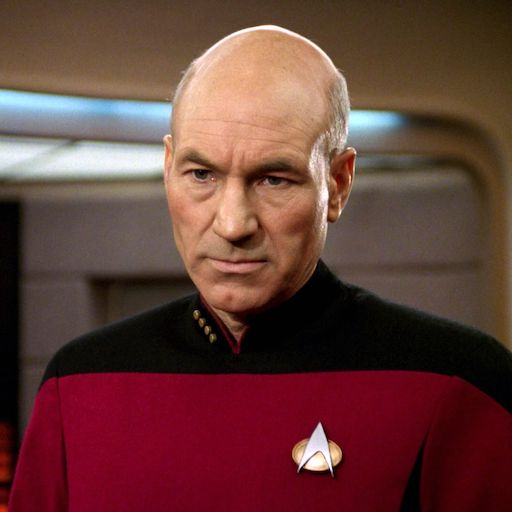

In [193]:
input_image = Image.open('images/picard.jpg')
# Start a new series of tests
images = [input_image]
prompts = ['Original']
input_image

0it [00:00, ?it/s]

Seed: 3392844891


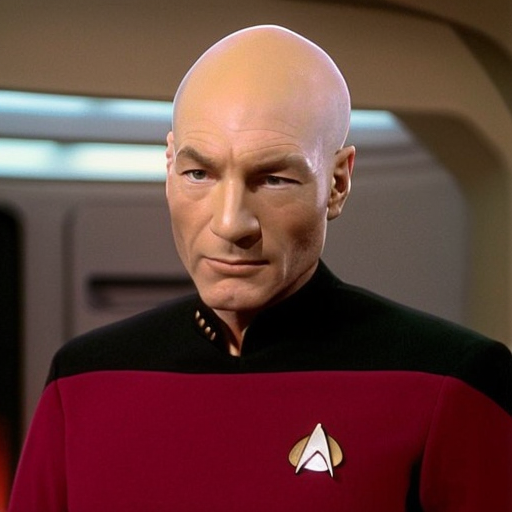

In [194]:
prompt = 'jean luc picard' + ', a scene from star trek tng'
image, seed = harness(prompt, input_image, seed=3392844891, edit_at=27)

0it [00:00, ?it/s]

Seed: 3392844891


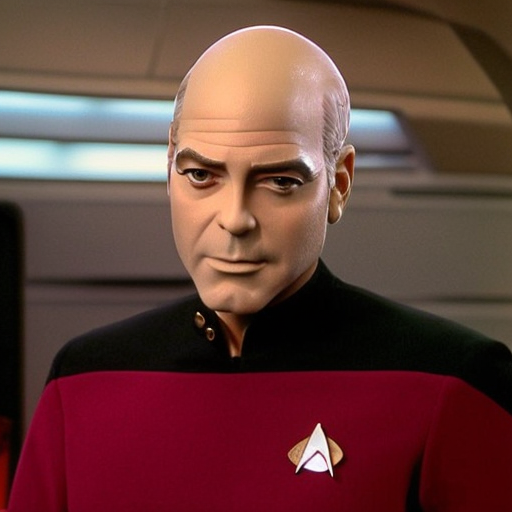

In [195]:
# Seed = 3392844891
add_to_grid(image, prompt)
prompt = 'george clooney' + ', a scene from star trek tng'
image, seed = harness(prompt, input_image, seed = seed, edit_at=27)

0it [00:00, ?it/s]

Seed: 3392844891


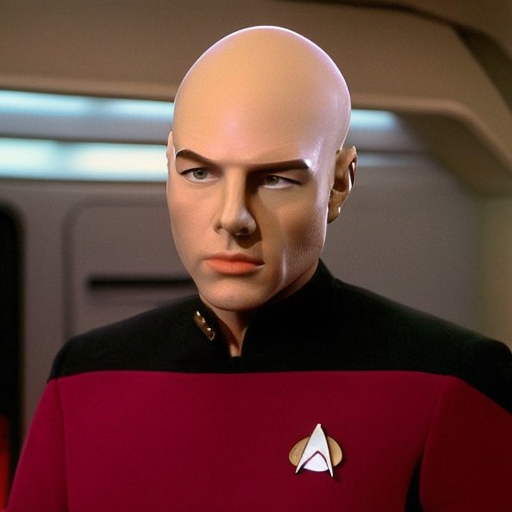

In [196]:
add_to_grid(image, prompt)
prompt = 'tom cruise' + ', a scene from star trek tng'
image, seed = harness(prompt, input_image, seed = seed, edit_at=27)

In [198]:
add_to_grid(image, prompt)

In [201]:
p_arr = ['kanye west', 'taylor swift', 'dwayne johnson', 'beyonce', 'prince charles', 'zendaya', 
    'arnold schwarzenegger', 'winston churchill', 'bill gates', 'queen latifah', 'janet jackson', 'rowan atkinson']

0it [00:00, ?it/s]

Seed: 3392844891


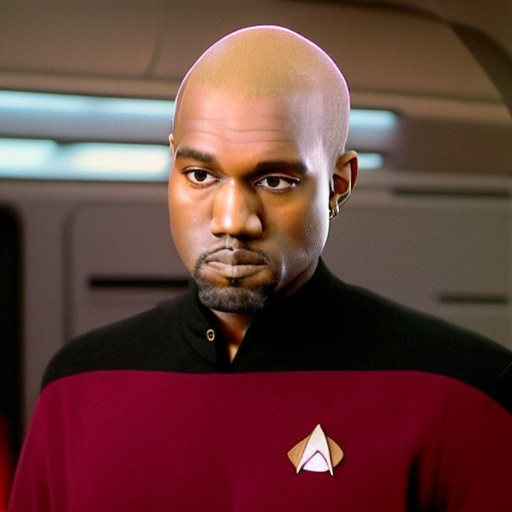

0it [00:00, ?it/s]

Seed: 3392844891


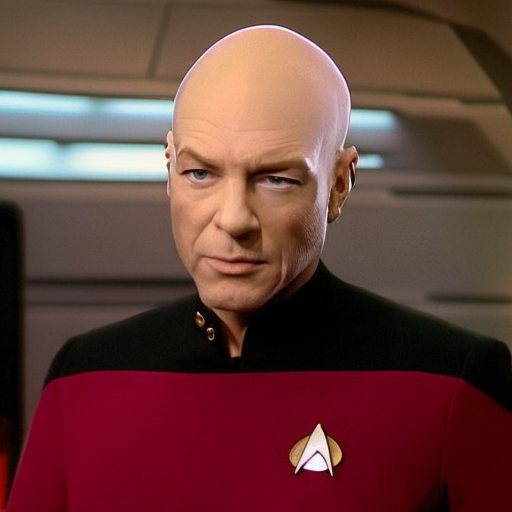

0it [00:00, ?it/s]

Seed: 3392844891


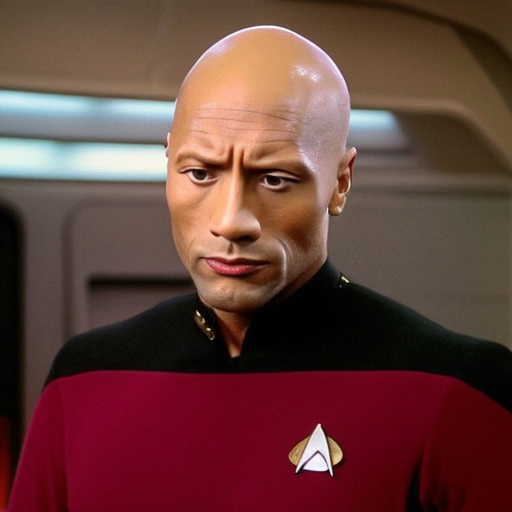

0it [00:00, ?it/s]

Seed: 3392844891


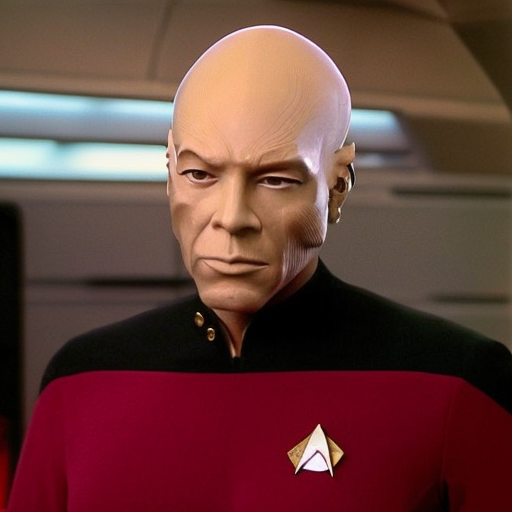

In [203]:
for p in p_arr[0:4]:
    prompt = p + ', a scene from star trek tng'
    image, seed = harness(prompt, input_image, seed = seed, edit_at=27)
    add_to_grid(image, prompt)

0it [00:00, ?it/s]

Seed: 3392844891


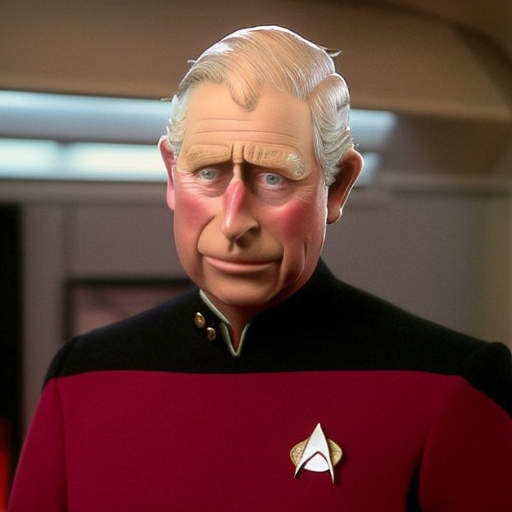

0it [00:00, ?it/s]

Seed: 3392844891


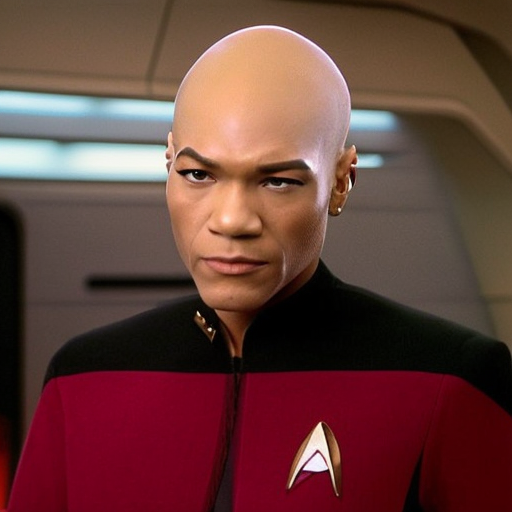

0it [00:00, ?it/s]

Seed: 3392844891


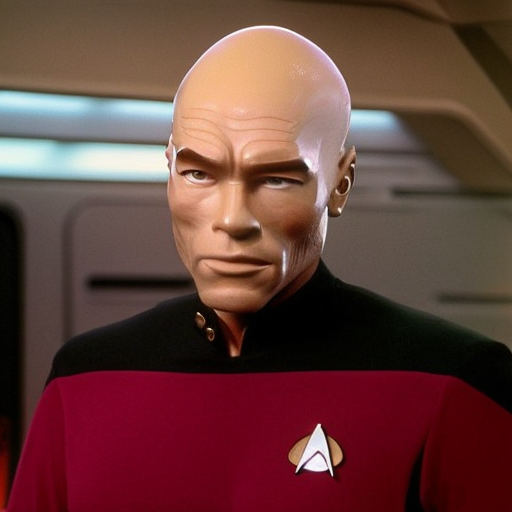

0it [00:00, ?it/s]

Seed: 3392844891


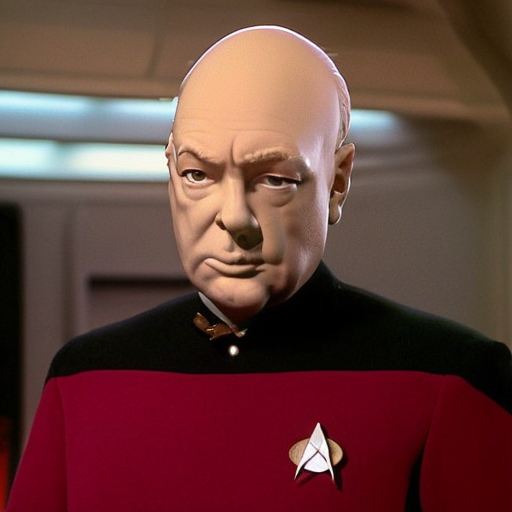

In [206]:
for p in p_arr[4:8]:
    prompt = p + ', a scene from star trek tng'
    image, seed = harness(prompt, input_image, seed = seed, edit_at=27)
    add_to_grid(image, prompt)

0it [00:00, ?it/s]

Seed: 3392844891


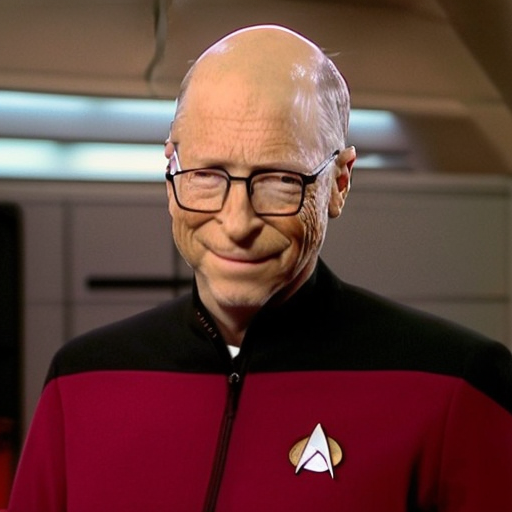

0it [00:00, ?it/s]

Seed: 3392844891


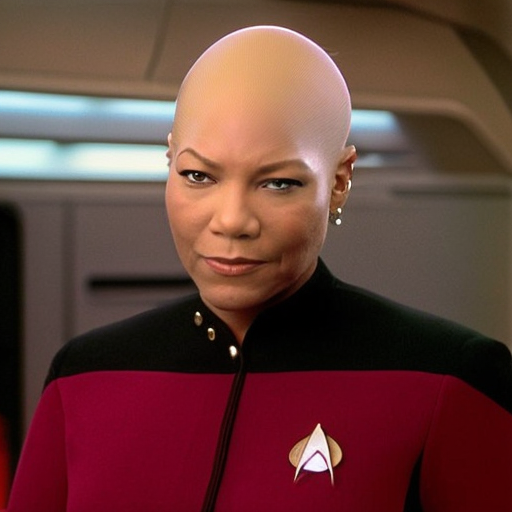

0it [00:00, ?it/s]

Seed: 3392844891


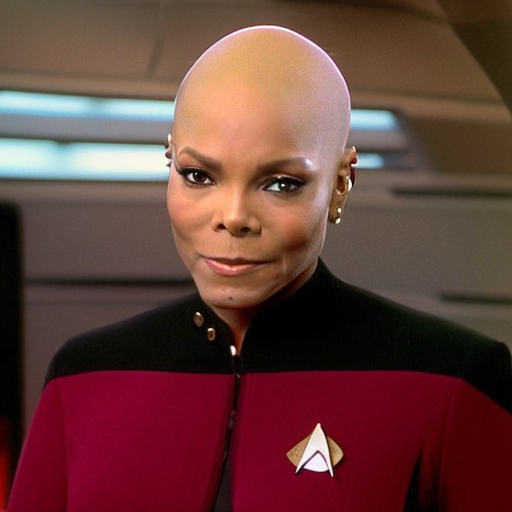

0it [00:00, ?it/s]

Seed: 3392844891


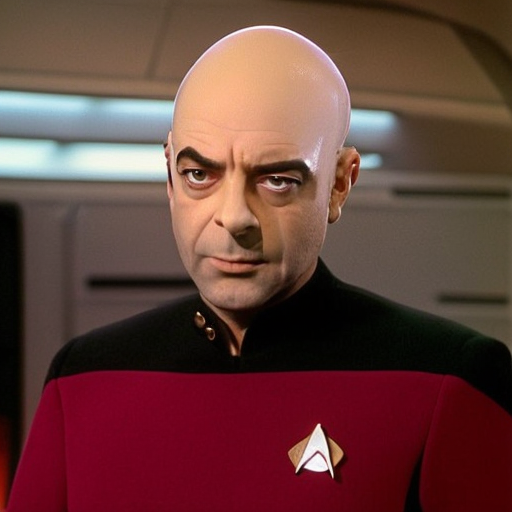

In [208]:
for p in p_arr[8:12]:
    prompt = p + ', a scene from star trek tng'
    image, seed = harness(prompt, input_image, seed = seed, edit_at=27)
    add_to_grid(image, prompt)

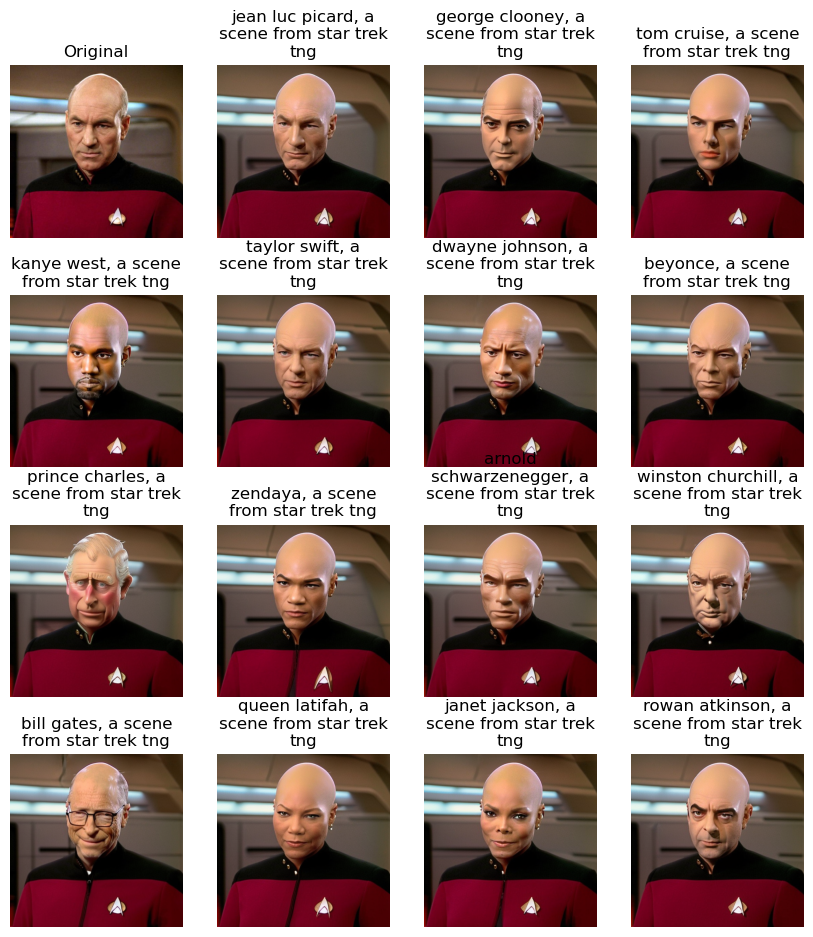

In [209]:
image_grid(images, rows=4, title=prompts)